In [1]:
import os

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

import nfl_data_py as nfl

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Features
* environmental factors
    * temperature
    * precipitation
    * wind
    * altitude
    * field surface
* situational factors
    * regular verse post season
    * situational pressure (score and time remaining)
    * home vers away
    * icing
    * kicking direction
* kicker ability
    fg% over average model


# Notes
* field goal post height increased to 5ft in 2014 (so only take 2014 on)

# Approach
1. An ensamble of models. One that first predicts FG% over expectation and then that feeds into overall model as predictor
    * two models: on that is predicts proba for 'average' kicker and one that is kicker specific


# TODO
* figure out if you need to adjust pre 2014 data based on field goal height, because you need that data for the first model
* then plot probability of field goal sucess by distance


In [2]:
years = range(2000, 2024)
cols = nfl.see_pbp_cols()

In [137]:
[col for col in cols if 'season' in col]

['season_type', 'season']

In [138]:
for c in cols:
    print(c)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [3]:
df_pbp = nfl.import_pbp_data(years)
df_pbp[df_pbp['field_goal_attempt'] == True].shape

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


(24471, 390)

In [4]:
variables = ['season','play_id','game_id','desc','kicker_player_name', 'kicker_player_id', 'field_goal_attempt', 'extra_point_attempt', 
             'fg_prob', 'field_goal_result', 'kick_distance']

df_fg = df_pbp[df_pbp['field_goal_attempt'] == True][variables].reset_index(drop=True)

In [143]:
df_fg.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_9135/655920156.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance_bin'] = pd.cut(df['kick_distance'], bins=bins, right=False)
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_9135/655920156.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = df.groupby('distance_bin')['field_goal_result'].apply(
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_9135/655920156.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

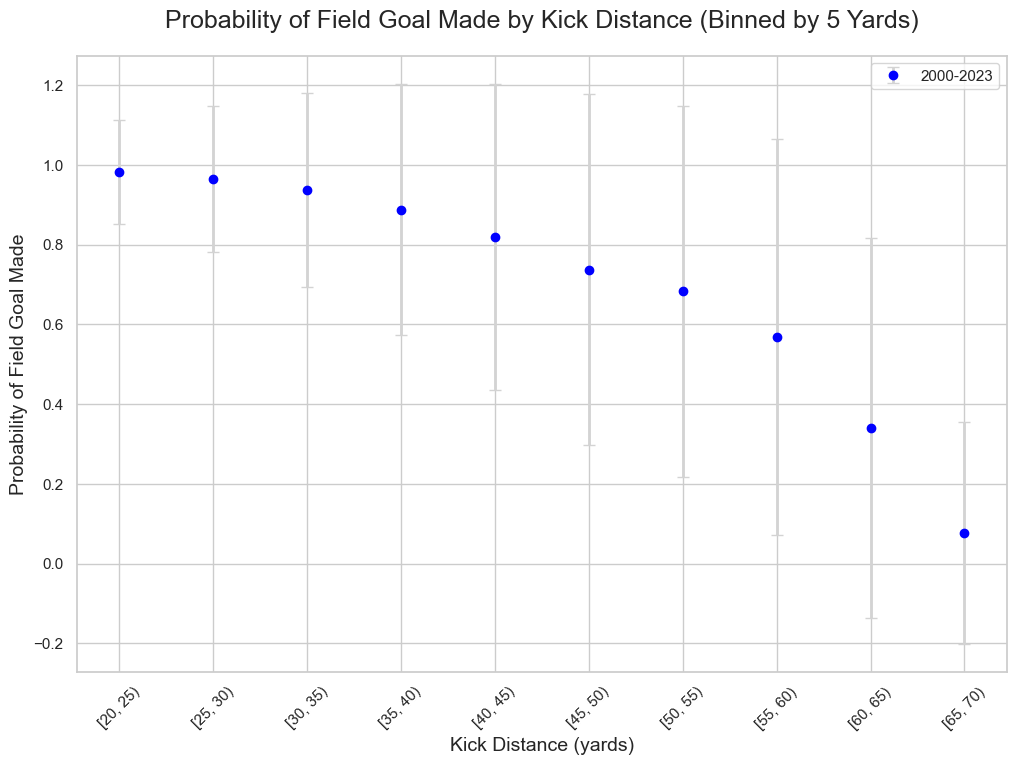

In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
# df = pd.read_csv('your_dataset.csv')  # Assuming you have a CSV file

# Filter the data into two subsets
df_all_years = df_fg[(2010 <= df_fg['season']) & (df_fg['season'] < 2024)]

# Define a function to calculate probabilities and standard deviation binned by 5 yards
def calculate_probabilities_and_std(df):
    bins = range(20, 71, 5)
    df['distance_bin'] = pd.cut(df['kick_distance'], bins=bins, right=False)
    prob_df = df.groupby('distance_bin')['field_goal_result'].apply(
        lambda x: (x == 'made').mean()).reset_index()
    std_df = df.groupby('distance_bin')['field_goal_result'].apply(
        lambda x: (x == 'made').std()).reset_index()
    prob_df.columns = ['distance_bin', 'probability']
    std_df.columns = ['distance_bin', 'std_dev']
    prob_std_df = pd.merge(prob_df, std_df, on='distance_bin')
    return prob_std_df

# Calculate probabilities and standard deviation for all years
prob_std_all_years = calculate_probabilities_and_std(df_all_years)

# Set the seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 8))
plt.errorbar(x=prob_std_all_years['distance_bin'].astype(str), y=prob_std_all_years['probability'], 
             yerr=prob_std_all_years['std_dev'], fmt='o', color='blue', ecolor='lightgray', 
             elinewidth=2, capsize=4, label='2000-2023')

# Customize the plot
plt.xlabel('Kick Distance (yards)', fontsize=14)
plt.ylabel('Probability of Field Goal Made', fontsize=14)
plt.title('Probability of Field Goal Made by Kick Distance (Binned by 5 Yards)', fontsize=18, pad=20)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

In [5]:
df_schedules = nfl.import_schedules(years)

sched_cols = ['game_id','roof','surface','wind','temp','stadium_id','stadium']
df = df_fg.merge(df_schedules[sched_cols], on='game_id', how='left')

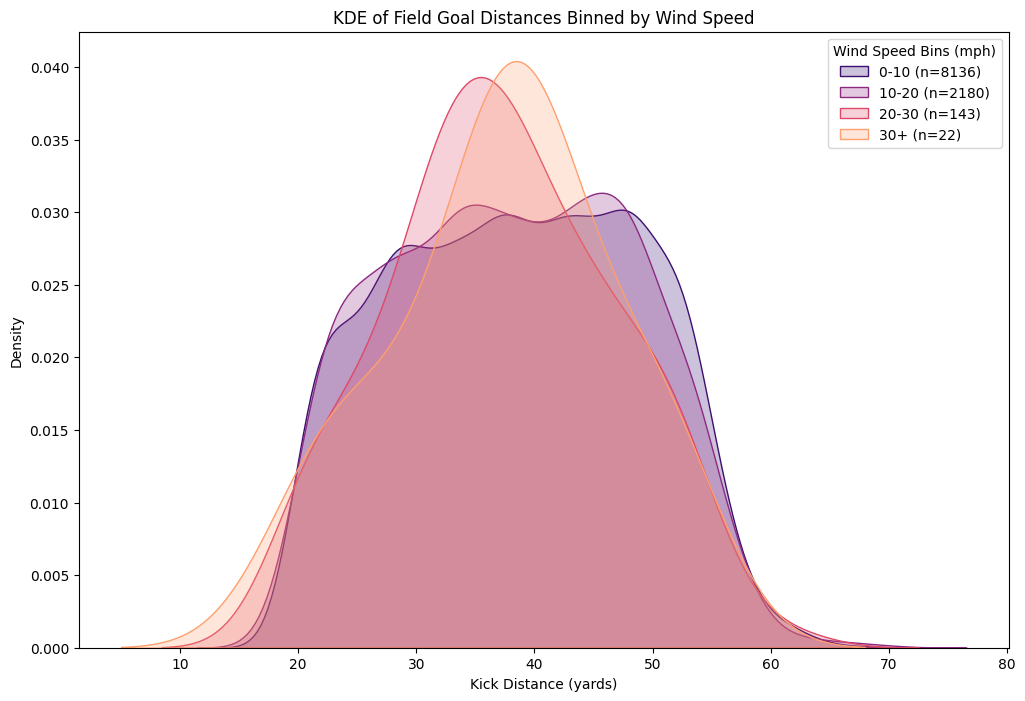

In [119]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Example DataFrame creation (if needed for context)
# data = {'kick_distance': [...], 'wind_speed': [...]}
# df = pd.DataFrame(data)

# Bin the wind speed
bins = [0, 10, 20, 30, float('inf')]
labels = ['0-10', '10-20', '20-30', '30+']
df['wind_speed_bin'] = pd.cut(df['wind'], bins=bins, labels=labels, right=False)

# Generate colors from the magma palette
colors = sns.color_palette("magma", len(labels))

# Plot the KDE
plt.figure(figsize=(12, 8))
for label, color in zip(labels, colors):
    subset = df[df['wind_speed_bin'] == label]
    sns.kdeplot(subset['kick_distance'], label=f'{label} (n={len(subset)})', fill=True, color=color)

# Add labels and legend
plt.xlabel('Kick Distance (yards)')
plt.ylabel('Density')
plt.title('KDE of Field Goal Distances Binned by Wind Speed')
plt.legend(title='Wind Speed Bins (mph)')
plt.show()


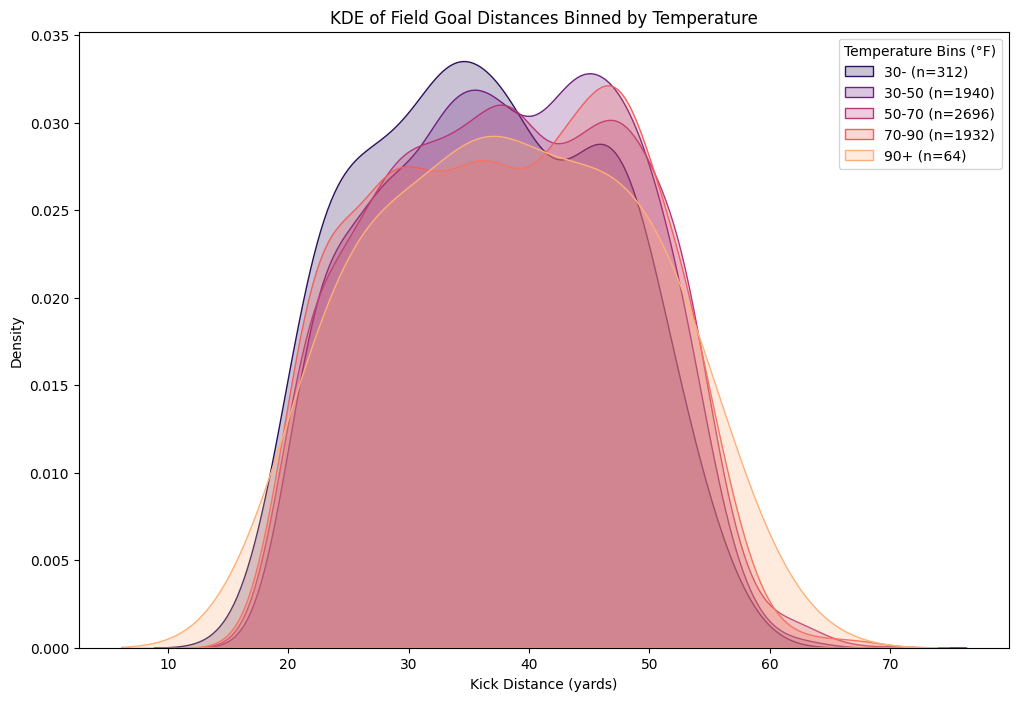

In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
# Example DataFrame creation (if needed for context)
# data = {'kick_distance': [...], 'temp': [...]} # Your data here
# df = pd.DataFrame(data)

# Bin the temperature
bins = [float('-inf'), 20, 30, 40, 50, 60, 70, 80, 90, float('inf')]
labels = ['20-', '20-40', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+']
bins = [float('-inf'), 30, 50, 70, 90, float('inf')]
labels = ['30-', '30-50', '50-70', '70-90', '90+']
df['temp_bin'] = pd.cut(df['temp'], bins=bins, labels=labels, right=False)

# Generate colors from the magma palette
colors = sns.color_palette("magma", len(labels))

# Plot the KDE
plt.figure(figsize=(12, 8))
for label, color in zip(labels, colors):
    subset = df[df['temp_bin'] == label]
    sns.kdeplot(subset['kick_distance'], label=f'{label} (n={len(subset)})', fill=True, color=color)

# Add labels and legend
plt.xlabel('Kick Distance (yards)')
plt.ylabel('Density')
plt.title('KDE of Field Goal Distances Binned by Temperature')
plt.legend(title='Temperature Bins (°F)')
plt.show()


In [168]:
df.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance,distance_bin,roof,surface,wind,temp,stadium_id,stadium
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0,"[30, 35)",outdoors,grass,3.0,80.0,NYC00,Giants Stadium
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0,"[20, 25)",outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0,"[25, 30)",outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0,"[30, 35)",outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0,"[45, 50)",outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium


In [218]:
df_slim = df[['kick_distance','wind','temp','roof','surface','field_goal_result']]

df_slim['field_goal_made'] = df_slim['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

df_slim = df_slim.drop(columns='field_goal_result')

# trim any whitespace around surface column strings
df_slim['surface'] = df_slim['surface'].str.strip()

# if surface is grass, set to 1, else 0
df_slim['grass'] = df_slim['surface'].apply(lambda x: 1 if x == 'grass' else 0)

# if outdoors, set to 1, else 0
df_slim['outdoors'] = df_slim['roof'].apply(lambda x: 1 if x == 'outdoors' else 0)

# drop roof and surface columns
df_slim = df_slim.drop(columns=['roof','surface'])

df_slim.wind = df_slim.wind.fillna(0)
df_slim.temp = df_slim.temp.fillna(68)

In [219]:
# move field_goal_made to the end
X_traindf_slim = df_slim[[col for col in df_slim if col != 'field_goal_made'] + ['field_goal_made']]
df_slim.head()

,kick_distance,wind,temp,grass,outdoors,field_goal_made
0,32.0,3.0,80.0,1,1,1
1,23.0,8.0,74.0,0,1,1
2,26.0,8.0,74.0,0,1,1
3,33.0,8.0,74.0,0,1,1
4,45.0,8.0,74.0,0,1,0


In [279]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Split the data into training and testing sets
X = df_slim.iloc[:, :-1]
y = df_slim.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.iloc[:, :-4]
X_test = X_test.iloc[:, :-4]

from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Add constant to the model (intercept)
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

y_train.reset_index(drop=True, inplace=True)
X_train_const.reset_index(drop=True, inplace=True)
X_test_const.reset_index(drop=True, inplace=True)

# Fit the logistic regression model using statsmodels
model = sm.Logit(y_train, X_train_const)
result = model.fit()

# Print the summary which includes p-values
print(result.summary())

# Make predictions on the test data
y_pred_prob = result.predict(X_test_const)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.4f}')

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)


# # Calculate the odds ratio for each feature
# odds_ratio = np.exp(result.params).flatten()
# odds_ratio_df = pd.DataFrame({'Feature': X_train_const.columns, 'Odds Ratio': odds_ratio})
# odds_ratio_df = odds_ratio_df.sort_values(by='Odds Ratio', ascending=False)
# print('Odds Ratio for Each Feature:')
# print(odds_ratio_df)

# # Plot the odds ratio for each feature
# plt.figure(figsize=(12, 8))
# sns.barplot(x='Odds Ratio', y='Feature', data=odds_ratio_df, palette='viridis')
# plt.xlabel('Odds Ratio')
# plt.ylabel('Feature')
# plt.title('Odds Ratio for Field Goal Success')
# plt.show()im


Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        field_goal_made   No. Observations:                19576
Model:                          Logit   Df Residuals:                    19574
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Jun 2024   Pseudo R-squ.:                  0.1281
Time:                        23:07:34   Log-Likelihood:                -7818.3
converged:                       True   LL-Null:                       -8967.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.8871      0.024     77.676      0.000       1.839       1.935
kick_distance    -1.

In [229]:
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f'Model Accuracy: {accuracy:.4f}')

Model Accuracy: 0.8373


In [230]:
df_slim.field_goal_made.mean()

0.8278778962853991

In [275]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.iloc[:, :-1]
X_test = X_test.iloc[:, :-1]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Add constant to the model (intercept)
X_train_const = sm.add_constant(X_train_scaled)
X_test_const = sm.add_constant(X_test_scaled)

# Initialize the Random Forest classifier with regularization
rf_classifier_regularized = RandomForestClassifier(random_state=42, max_depth=6, min_samples_split=5, min_samples_leaf=2, max_features='sqrt')

# Fit the regularized classifier to the training data
rf_classifier_regularized.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred_regularized = rf_classifier_regularized.predict(X_test_scaled)

# Calculate the accuracy of the regularized model
accuracy_regularized = accuracy_score(y_test, y_pred_regularized)
print(f'Regularized Model Accuracy: {accuracy_regularized:.4f}')

# Create a confusion matrix for the regularized model
cm_regularized = confusion_matrix(y_test, y_pred_regularized)
print('Confusion Matrix (Regularized Model):')
print(cm_regularized)

Regularized Model Accuracy: 0.8300
Confusion Matrix (Regularized Model):
[[  42  815]
 [  17 4021]]


In [276]:
y_pred = rf_classifier_regularized.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.83


Top 10 Most Important Features:
         Feature  Importance
0  kick_distance    0.874917
2           temp    0.063548
1           wind    0.052365
3          grass    0.009170


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_9135/1358160366.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')


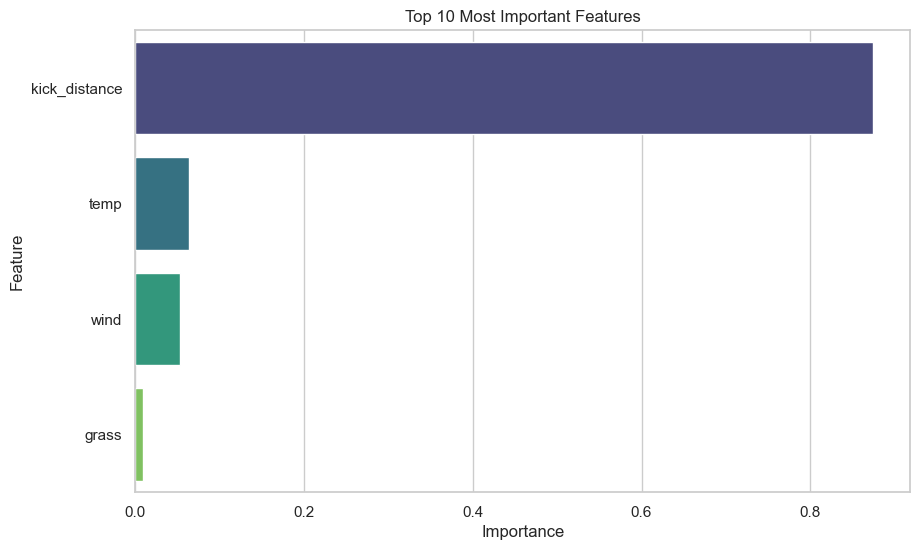

In [277]:
# Get feature importances from the trained random forest model
feature_importances = rf_classifier_regularized.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': feature_importances})

# Sort the DataFrame by feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the top N most important features
top_n = 10
print(f'Top {top_n} Most Important Features:')
print(feature_importance_df.head(top_n))

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()


In [278]:
df.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance,roof,surface,wind,temp,stadium_id,stadium
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0,outdoors,grass,3.0,80.0,NYC00,Giants Stadium
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium


In [281]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Split the data into training and testing sets
X = df_slim.iloc[:, :-1]
y = df_slim.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.iloc[:, :-4]
X_test = X_test.iloc[:, :-4]

# Add constant to the model (intercept)
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

y_train.reset_index(drop=True, inplace=True)
X_train_const.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_test_const.reset_index(drop=True, inplace=True)

# Fit the logistic regression model using statsmodels
model = sm.Logit(y_train, X_train_const)
result = model.fit()

# Print the summary which includes p-values
print(result.summary())

# Make predictions on the test data
y_pred_prob = result.predict(X_test_const)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.4f}')


Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        field_goal_made   No. Observations:                19576
Model:                          Logit   Df Residuals:                    19574
Method:                           MLE   Df Model:                            1
Date:                Sat, 01 Jun 2024   Pseudo R-squ.:                  0.1281
Time:                        23:13:07   Log-Likelihood:                -7818.3
converged:                       True   LL-Null:                       -8967.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.6063      0.102     54.862      0.000       5.406       5.807
kick_distance    -0.

In [287]:
X_all= sm.add_constant(df.kick_distance)
df['field_goal_proba'] = result.predict(X_all)

In [289]:
# add field_goal_made to df if field_gaol_result is "made"
df['field_goal_made'] = df['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)

In [290]:
df.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance,roof,surface,wind,temp,stadium_id,stadium,field_goal_proba,field_goal_made
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0,outdoors,grass,3.0,80.0,NYC00,Giants Stadium,0.918317,1
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,0.964972,1
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,0.953345,1
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,0.910530,1
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,0.754940,0


In [309]:
# rank the 2023 season kickers by total field goal percentage over expectation
# this metric is field_goal_made - field_goal_proba for all kicks a kicker attemted

df_kickers = df.groupby('kicker_player_name').agg({'field_goal_made':'sum','field_goal_proba':'sum','field_goal_attempt':'sum'}).reset_index()
df_kickers['fg_pct_over_exp'] = df_kickers['field_goal_made'] - df_kickers['field_goal_proba']
df_kickers['fg_pct_over_exp'] = df_kickers['fg_pct_over_exp'] / df_kickers['field_goal_made']
df_kickers = df_kickers.sort_values(by='fg_pct_over_exp', ascending=False)
df_kickers.query('field_goal_attempt > 100').head(40)

,kicker_player_name,field_goal_made,field_goal_proba,field_goal_attempt,fg_pct_over_exp
96,J.Tucker,413,368.605931,460.0,0.107492
52,E.McPherson,97,87.605394,112.0,0.096852
62,H.Butker,229,210.782502,257.0,0.079552
195,Y.Koo,154,142.142946,174.0,0.076994
119,M.Gay,146,135.300115,170.0,0.073287
26,C.Boswell,248,231.041548,282.0,0.068381
74,J.Elliott,184,171.782164,211.0,0.066401
85,J.Lambo,132,123.238521,151.0,0.066375
45,D.Carlson,173,162.041089,196.0,0.063346
103,K.Fairbairn,180,169.268775,208.0,0.059618


In [308]:
df_kickers = df.groupby('kicker_player_name').agg({'field_goal_made':'sum','fg_prob':'sum','field_goal_attempt':'sum'}).reset_index()
df_kickers['fg_pct_over_exp'] = df_kickers['field_goal_made'] - df_kickers['fg_prob']
df_kickers['fg_pct_over_exp'] = df_kickers['fg_pct_over_exp'] / df_kickers['field_goal_made']
df_kickers = df_kickers.sort_values(by='fg_pct_over_exp', ascending=False)
df_kickers.query('field_goal_attempt > 100').head(40)

,kicker_player_name,field_goal_made,fg_prob,field_goal_attempt,fg_pct_over_exp
96,J.Tucker,413,381.251434,460.0,0.076873
52,E.McPherson,97,91.611290,112.0,0.055554
62,H.Butker,229,218.795227,257.0,0.044562
26,C.Boswell,248,239.453857,282.0,0.034460
74,J.Elliott,184,178.241821,211.0,0.031294
85,J.Lambo,132,127.923340,151.0,0.030884
89,J.Nedney,212,206.098862,251.0,0.027836
195,Y.Koo,154,149.939255,174.0,0.026368
129,M.Stover,291,283.580902,335.0,0.025495
84,J.Kasay,270,263.333862,322.0,0.024689


In [ ]:
# TODO: score accuracy of baysian verse logisitc and RF models

In [6]:
df_fg.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0


In [7]:
df['field_goal_made'] = df['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)
df.head()

,season,play_id,game_id,desc,kicker_player_name,kicker_player_id,field_goal_attempt,extra_point_attempt,fg_prob,field_goal_result,kick_distance,roof,surface,wind,temp,stadium_id,stadium,field_goal_made
0,2000,2771.0,2000_01_ARI_NYG,"(:05) C.Blanchard 32 yard field goal is GOOD, ...",C.Blanchard,00-0001343,1.0,0.0,0.883224,made,32.0,outdoors,grass,3.0,80.0,NYC00,Giants Stadium,1
1,2000,467.0,2000_01_BAL_PIT,"(8:21) M.Stover 23 yard field goal is GOOD, Ce...",M.Stover,00-0015784,1.0,0.0,0.956671,made,23.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,1
2,2000,1810.0,2000_01_BAL_PIT,"(:11) M.Stover 26 yard field goal is GOOD, Cen...",M.Stover,00-0015784,1.0,0.0,0.920074,made,26.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,1
3,2000,2027.0,2000_01_BAL_PIT,"(15:00) M.Stover 33 yard field goal is GOOD, C...",M.Stover,00-0015784,1.0,0.0,0.859976,made,33.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,1
4,2000,2250.0,2000_01_BAL_PIT,"(11:31) K.Brown 45 yard field goal is No Good,...",K.Brown,00-0001980,1.0,0.0,0.686317,missed,45.0,outdoors,astroturf,8.0,74.0,PIT99,Three Rivers Stadium,0


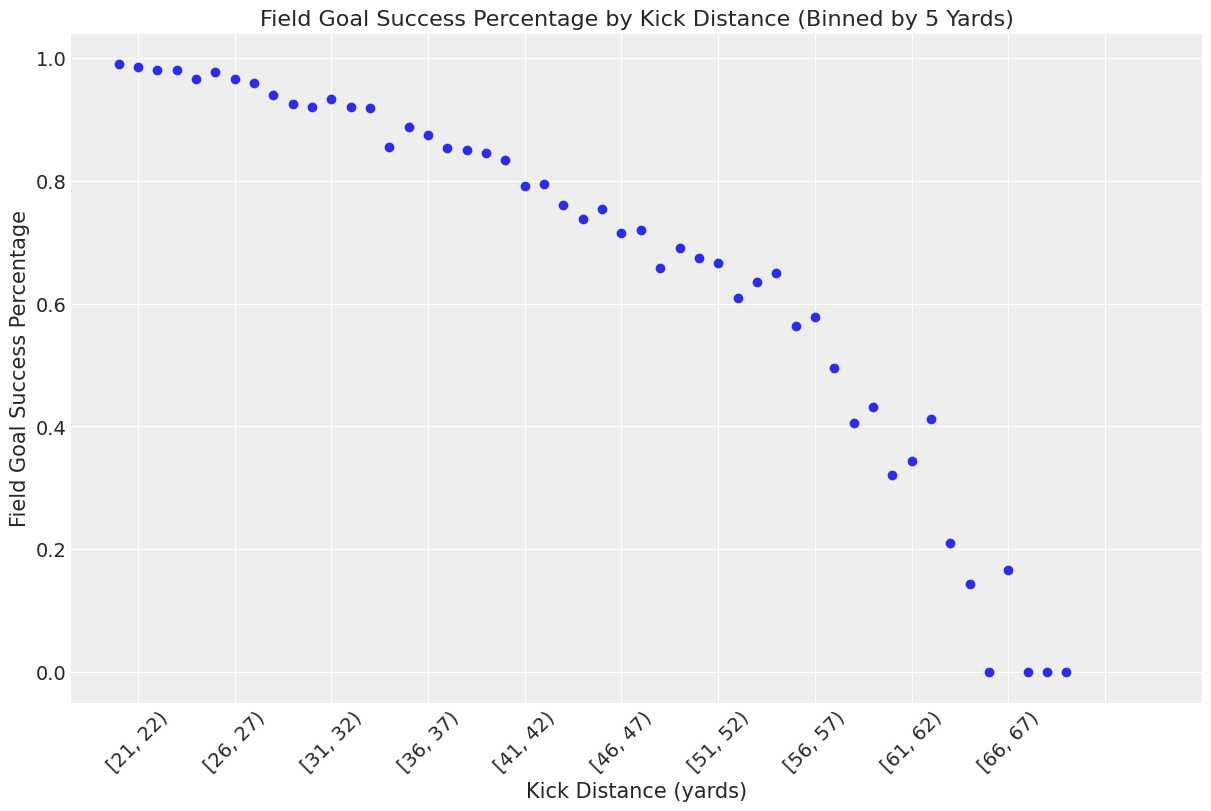

In [10]:
# generate plot of field goal sucess percentage binned by kick distance
import matplotlib.pyplot as plt
import seaborn as sns

# Bin the kick distance
bins = range(20, 71, 1)
df['distance_bin'] = pd.cut(df['kick_distance'], bins=bins, right=False)

# Calculate the field goal success percentage for each distance bin
fg_success_pct = df.groupby('distance_bin')['field_goal_made'].mean()

x = fg_success_pct.index.astype(str)
y = fg_success_pct

# Plot the field goal success percentage by distance
plt.figure(figsize=(12, 8))
plt.scatter(x, y)
plt.xlabel('Kick Distance (yards)')
plt.ylabel('Field Goal Success Percentage')
plt.title('Field Goal Success Percentage by Kick Distance (Binned by 5 Yards)')
plt.xticks(np.arange(1, 60, 5.0))
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [8]:
#count the number of field goals attempted and made by distance
df['field_goal_made'] = df['field_goal_result'].apply(lambda x: 1 if x == 'made' else 0)
df_fg = df[df['field_goal_attempt'] == True]
df_fg = df_fg.groupby('kick_distance').agg({'field_goal_attempt':'count','field_goal_made':'sum'}).reset_index()
df_fg = (df_fg.sort_values(by='kick_distance', ascending=True)
              .rename({'field_goal_attempt':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))
df_fg.head()

,kick_distance,field_goal_attempts,field_goal_makes
0,18.0,34,34
1,19.0,239,237
2,20.0,495,490
3,21.0,524,516
4,22.0,629,617


In [21]:
X = df_fg[['kick_distance']].values
n = df_fg['field_goal_attempts'].values
y = df_fg['field_goal_makes'].values

num_cores = os.cpu_count()

with pm.Model() as model:
    # Priors for the intercept and slope
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    
    # Linear combination
    linear_comb = alpha + beta * X
    
    # Logistic function to get the probabilities
    theta = pm.Deterministic('theta', pm.math.sigmoid(linear_comb)).flatten()
    
    # Binomial likelihood
    y_obs = pm.Binomial('y_obs', n=n, p=theta, observed=y)
    
    # Sampling
    trace = pm.sample(1000, tune=5000, chains=10, cores=num_cores, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (10 chains in 8 jobs)
NUTS: [alpha, beta]


/Users/lukeneuendorf/Projects/4th_Down/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 10 chains for 5_000 tune and 1_000 draw iterations (50_000 + 10_000 draws total) took 11 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


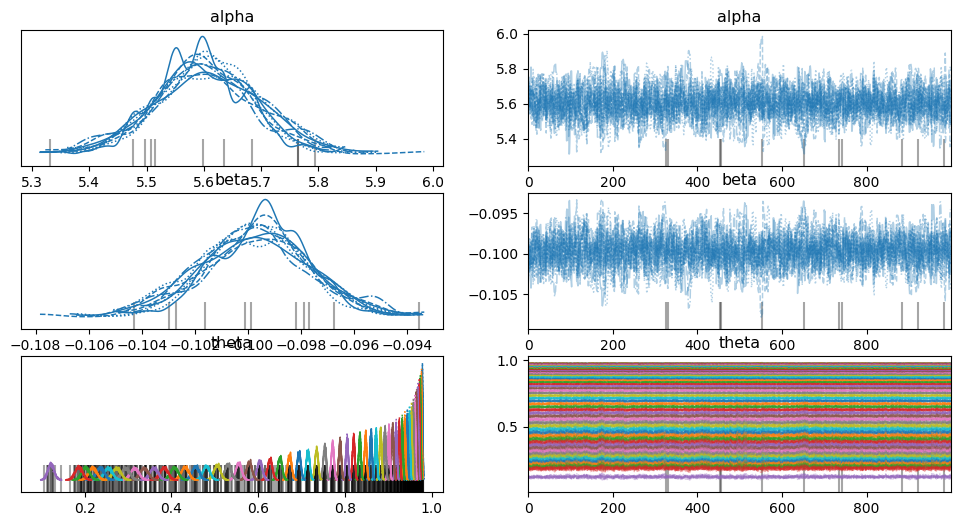

               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha         5.603  0.089   5.436    5.772      0.002    0.002    1613.0   
beta         -0.100  0.002  -0.103   -0.096      0.000    0.000    1682.0   
theta[0, 0]   0.978  0.001   0.976    0.980      0.000    0.000    1648.0   
theta[1, 0]   0.976  0.001   0.974    0.978      0.000    0.000    1656.0   
theta[2, 0]   0.974  0.001   0.971    0.976      0.000    0.000    1664.0   
theta[3, 0]   0.971  0.001   0.969    0.974      0.000    0.000    1674.0   
theta[4, 0]   0.968  0.001   0.965    0.971      0.000    0.000    1685.0   
theta[5, 0]   0.965  0.002   0.962    0.968      0.000    0.000    1698.0   
theta[6, 0]   0.961  0.002   0.958    0.964      0.000    0.000    1714.0   
theta[7, 0]   0.957  0.002   0.954    0.960      0.000    0.000    1734.0   
theta[8, 0]   0.953  0.002   0.950    0.956      0.000    0.000    1757.0   
theta[9, 0]   0.948  0.002   0.945    0.952      0.000    0.000    1785.0   

In [22]:
# Plot the posterior distributions
az.plot_trace(trace)
plt.show()

# Summary statistics
print(az.summary(trace))

<Axes: >

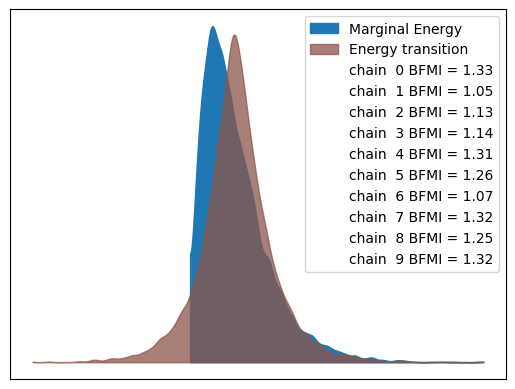

In [24]:
pm.plot_energy(trace)

/Users/lukeneuendorf/Projects/4th_Down/.venv/lib/python3.10/site-packages/arviz/plots/plot_utils.py:272: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (57) in plot_posterior, generating only 40 plots
  warnings.warn(


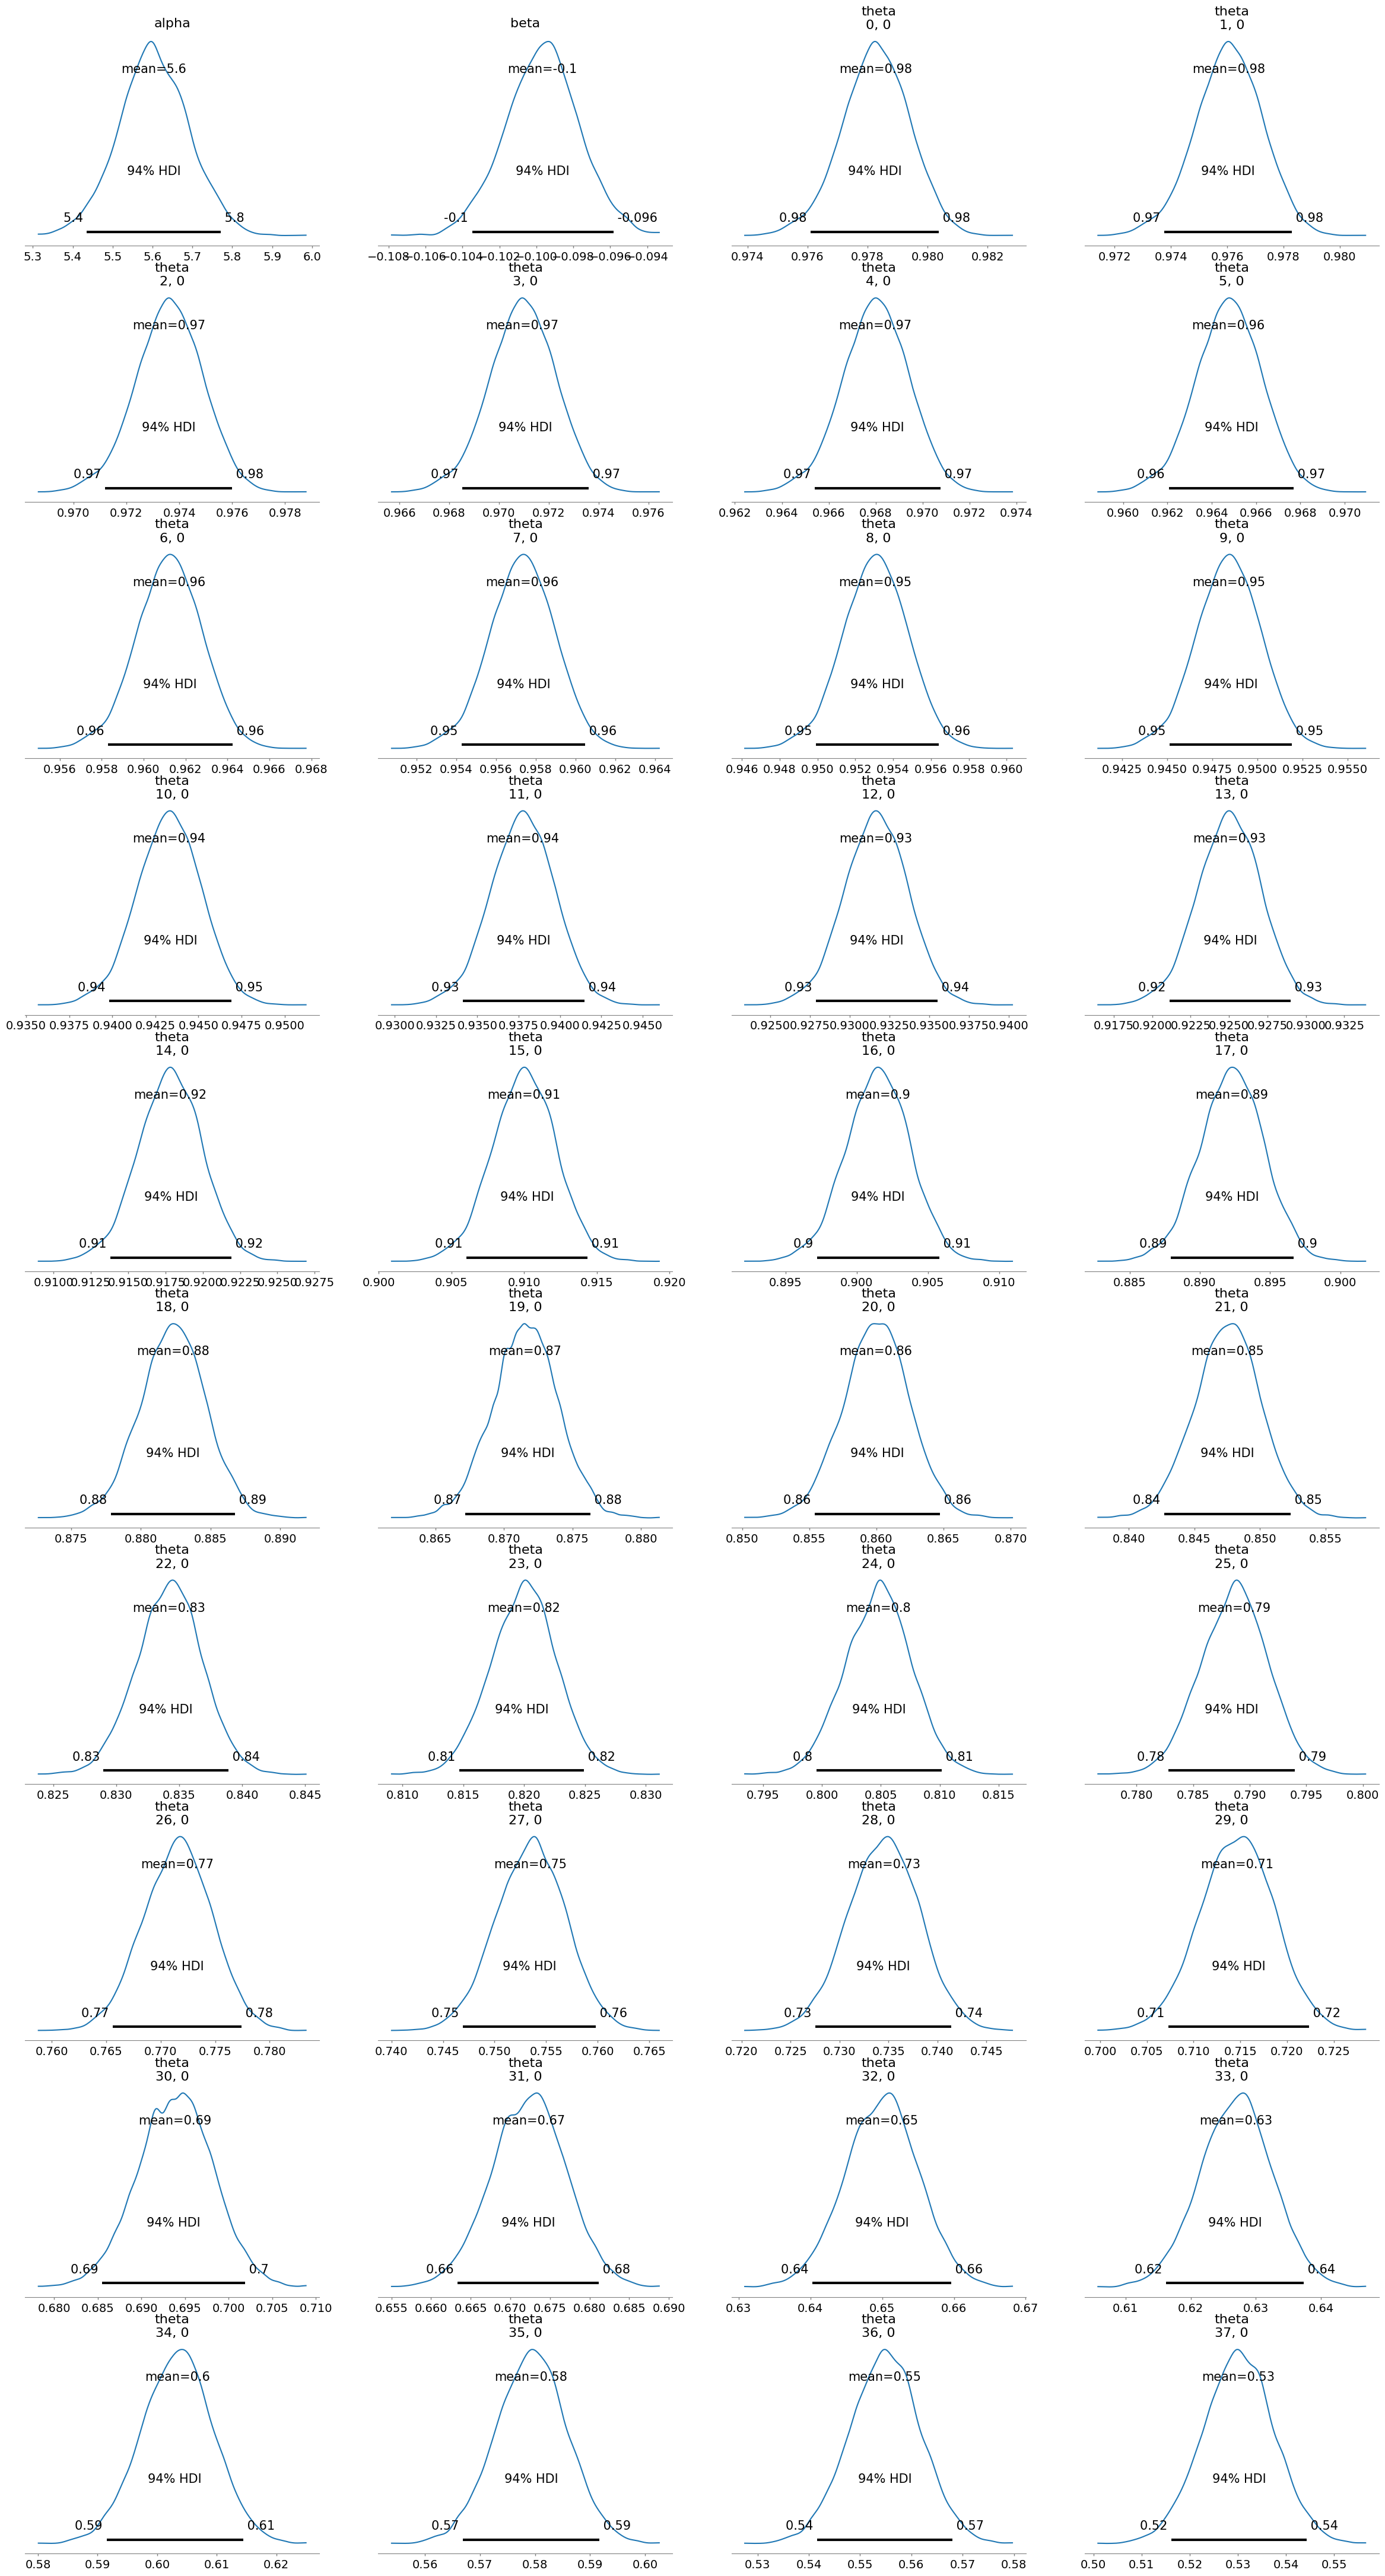

In [25]:
pm.plot_posterior(trace);

In [28]:
# Perform posterior predictive sampling
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace)

# Plot some of these predictions against the observed data
# Use the predicted number of makes (`field_goal_makes`)
predicted_makes = posterior_predictive['y_obs']

# Compare observed vs predicted makes
plt.figure(figsize=(10, 6))
plt.hist(predicted_makes.mean(axis=0), bins=30, alpha=0.5, label='Predicted Makes')
plt.hist(y, bins=30, alpha=0.5, label='Observed Makes')
plt.xlabel('Number of Field Goal Makes')
plt.ylabel('Frequency')
plt.title('Observed vs Predicted Field Goal Makes')
plt.legend()
plt.show()


Sampling: [y_obs]


/Users/lukeneuendorf/Projects/4th_Down/.venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

KeyError: 'y_obs'

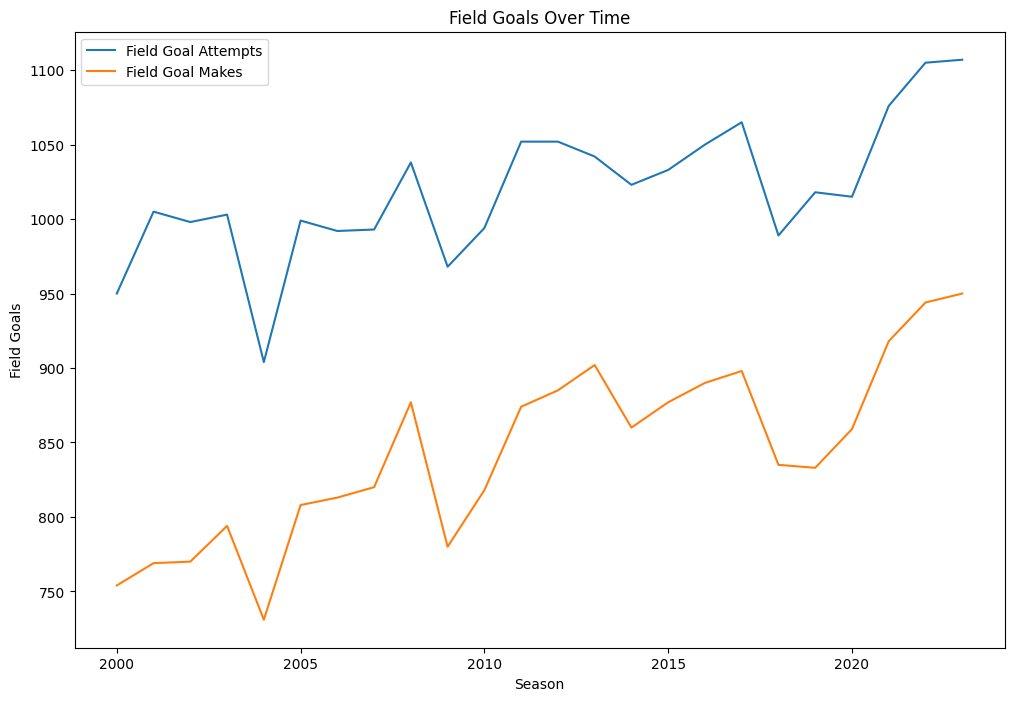

In [30]:
# see if number of field goal attempts is constant by season
df_fg = df[df['field_goal_attempt'] == True]
df_fg = df_fg.groupby('season').agg({'field_goal_attempt':'count','field_goal_made':'sum'}).reset_index()
df_fg = (df_fg.sort_values(by='season', ascending=True)
              .rename({'field_goal_attempt':'field_goal_attempts','field_goal_made':'field_goal_makes'}, axis=1))
# plot it over time
plt.figure(figsize=(12, 8))
plt.plot(df_fg['season'], df_fg['field_goal_attempts'], label='Field Goal Attempts')
plt.plot(df_fg['season'], df_fg['field_goal_makes'], label='Field Goal Makes')
plt.xlabel('Season')
plt.ylabel('Field Goals')
plt.title('Field Goals Over Time')
plt.legend()
